# Image Classification on Custom Food Dataset (Pizza, Steak, Sushi)

This notebook demonstrates how to load and work with a custom image dataset in PyTorch. The dataset is a small subset of Food101, containing only three classes: Pizza, Steak, and Sushi. We'll use this dataset to train a basic image classifier.

Key topics:
- Downloading and preparing a custom dataset
- Creating PyTorch `Dataset` and `DataLoader` objects
- Defining and training a convolutional neural network (CNN)

In [ ]:
#custom dataset into pytorch
#pytorch domain libraries: vision, audio, text, data and so on

import torch
from torch import nn

device = "mps" if torch.mps.is_available else "cpu"
# device="cpu"
import os
os.cpu_count()

11

In [37]:
#building a model to work with custom images
#food classifier

#get data, which is subset of Food101, which has 101 classes of food.
#This subset has 3 classes and only 100 images per class, as compared to 1000
#images per class in the original

# Download data

In [38]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists...skipping download")
else:
    print(f"{image_path} does not exist, creating now...")
    image_path.mkdir(parents=True, exist_ok=True)

#download
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print(f"Downloading data...")
    f.write(request.content)

#unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping download
Unzipping...


In [39]:
#the plan is to load any dataset and then convert it into tensors
#data exploration and prep

import os

def walk_through_dir(dir_path):
    """Walks through the directory revealing its contents"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

walk_through_dir(image_path)


There are 2 directories and 1 images in 'data/pizza_steak_sushi
There are 3 directories and 1 images in 'data/pizza_steak_sushi/test
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza
There are 3 directories and 1 images in 'data/pizza_steak_sushi/train
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza


## Dataset: Pizza, Steak, Sushi Subset

We use a small subset of the Food101 dataset (originally with 101 classes). This subset includes:

- 3 classes: Pizza, Steak, Sushi
- 100 images per class
- Train/test split already structured into folders

Images are downloaded directly from a zip file hosted on GitHub and extracted into the working directory.


In [40]:
#Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

#class name is folder name within the train and test folders, 
# this is standard, and then each class folder has the data for 
# that class, in this case is images

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/test/pizza/2236338.jpg
pizza
512 512


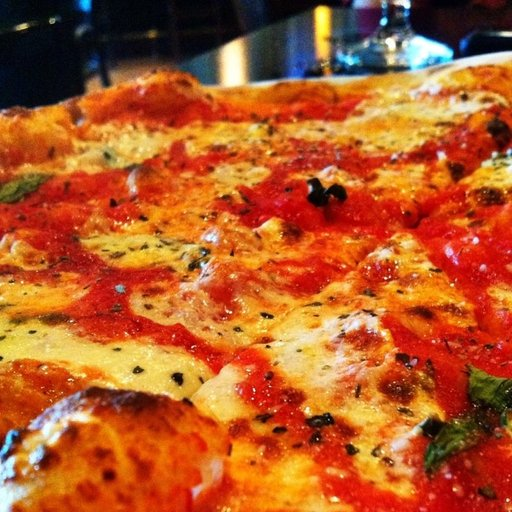

In [41]:
#visualizing images
#random image

#steps: get all image paths, grab random image using random.choice() 
# and get image class name using `pathlib.Path.parent.stem`
#opne image with pillow (PIL python image library)

import random
from PIL import Image

random.seed(42)

#get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

#open image
img = Image.open(random_image_path)
print(img.height, img.width)
img

(512, 512, 3)
[[[  7  18  38]
  [  5  16  36]
  [  2  13  31]
  ...
  [ 17   8   9]
  [ 12   6   8]
  [  8   4   5]]

 [[  2  13  33]
  [  2  13  33]
  [  2  13  31]
  ...
  [ 18   9  10]
  [ 17  11  13]
  [ 16  12  13]]

 [[  0  11  29]
  [  1  12  30]
  [  3  14  32]
  ...
  [ 17   8   9]
  [ 16  10  12]
  [ 15  11  12]]

 ...

 [[226 249 255]
  [229 253 255]
  [230 254 254]
  ...
  [252 148  95]
  [242 138  83]
  [234 131  73]]

 [[222 247 254]
  [224 252 255]
  [226 255 253]
  ...
  [238 133  88]
  [195  88  42]
  [169  62  16]]

 [[219 246 253]
  [224 252 255]
  [224 254 252]
  ...
  [255 156 116]
  [207 100  58]
  [163  54  13]]]


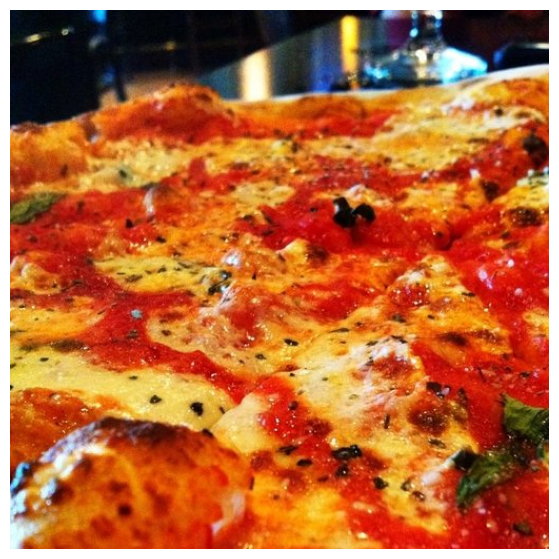

In [42]:
#visualizing image using matplotlib
import matplotlib.pyplot as plt
import numpy as np

#turn img into array

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)
print(img_as_array.shape) #HWC, but pytorch expects CHW
print(img_as_array)

In [43]:
#now we turn all images into pytorch tensors
#steps; turn images into tensors
#turn it into `torch.utils.data.Dataset` and 
# then wrap it with `torch.utils.data.DataLoader` 
# and we will call these Dataset and DataLoader

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#jpg to tensor
data_transform = transforms.Compose([ #chain together transforms
    transforms.Resize(size=(64,64)), #for using with a baseline/transfer learning model
    transforms.RandomHorizontalFlip(p=0.5), #random images (half of all) flipped on horizontal axis
    transforms.ToTensor(), #converts HWC to CHW
])

# data_transform(img).dtype


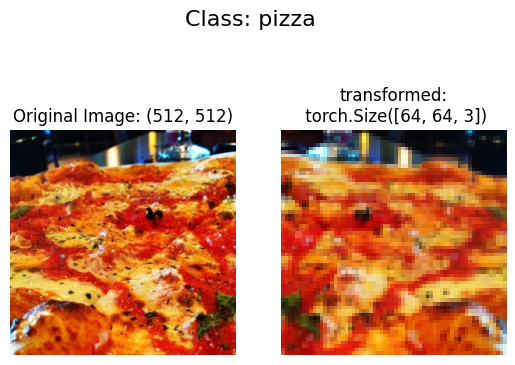

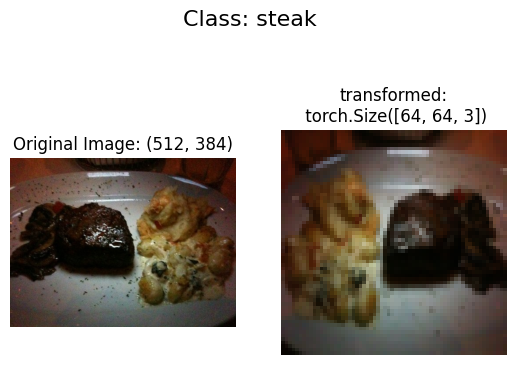

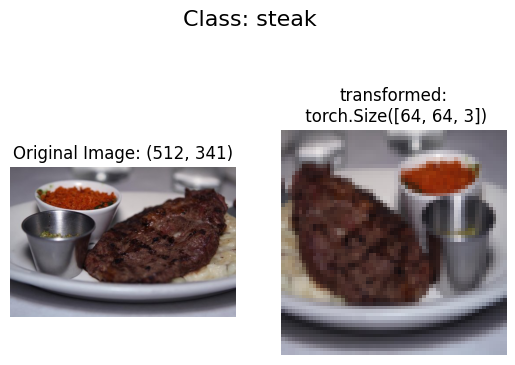

In [44]:
#now we do this for every image
#and compare the transform with original image

def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """Selects random images from a path of images and transforms them, and the
    n compares it with original image"""

    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Image: {f.size}")
            ax[0].axis(False)

            #transform and plot target image
            transformed_image = transform(f).permute(1,2,0) #CHW back to HWC for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed:\n {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


In [45]:
#OPTION1: Specific to images
# loading image data using "ImageFolder"
#prebuilt data loader for images
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) #a transform for label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(train_data, test_data)
# print(train_data.classes)
class_names = train_data.classes #as list
class_dict = train_data.class_to_idx #as dict, the transform in line 4 would transform this

print(class_names, class_dict)

len(train_data), len(test_data)


Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}


(225, 75)

In [46]:
#visualizing a sample and label from the ImageFolder dataset

#index on train_data dataset to get a single image and label
print(train_data[0])
img, label = train_data[0][0], train_data[0][1]
img, label, img.shape, img.dtype, type(label)

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0902, 0.0902, 0

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

torch.Size([64, 64, 3])


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

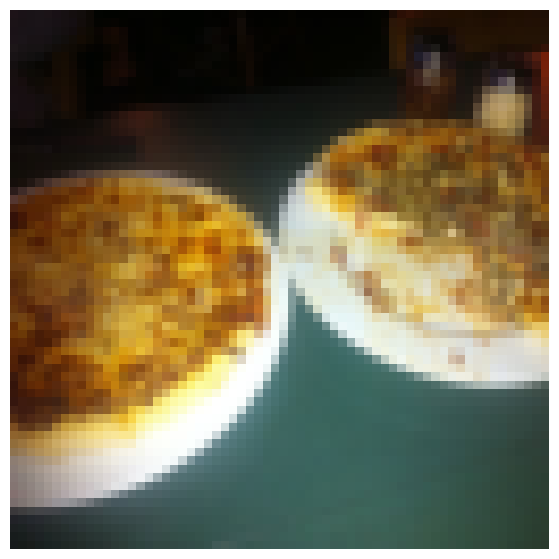

In [47]:
#use matplotlib to plot
img_permute = img.permute(1,2,0) #CHW to HWC for matplotlib
print(img_permute.shape)

#plot
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)

In [48]:
#batching images from ImageData using a DataLoader
#datasets into data loader
#torch.utils.data.DataLoader

#turn train and test data into DataLoader
BATCH_SIZE=32

train_dataloader =DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True)

test_dataloader =DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader) #len depends on batchsize




(<torch.utils.data.dataloader.DataLoader at 0x13830dc00>,
 8,
 3)

In [49]:
#now try to plot image from the dataloader

img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
#OPTION2: using a custom DataLoader and not prebuilt ones
#replicate functionality of ImageFolder
#basically the ability to extract classes and classes as dict
#to be able to work with DataLoader

#build on torch.utils.data.Dataset
#pros: create dataset out of almost anything, not limited to prebuilt functions
#cons: won't always work the way we want, needs writing more code (could be prone to errors or performance issues)

import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

#trying to replicate ImageFolder which is
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [51]:
#helper function to grab class names. directory needs to be in a structure similar to above

target_directory = train_dir

print(f"target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target directory: data/pizza_steak_sushi/train


['.DS_Store', 'pizza', 'steak', 'sushi']

In [52]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    #Get class names by scanning through directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # print(type(classes))
    #classes = classes[1:]
    print(classes)
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes")
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(target_directory)

['pizza', 'steak', 'sushi']


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [53]:
#now replicating what ImageFolder does:
#all datasets map from keys to data samples should subclass torch.utils.data.Dataset
#should overwrite __get_item__() or __len__()
#This is to be able to use with DataLoader

#steps: subclass Dataset
#init our subclass from a target directory, and transform the data
#create attributes: paths of images, transform, classes, class_to_idx

#create a function to loa iamges, overwrite the __len__() method to return length of dataset
#overwrite the __get_item()__ method

In [54]:
#subclass torch.utils.data.Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, 
                 targ_dir: str,
                 transform=None):
        #get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) #accessing train and test as the targ_dir
        self.transform = transform
        #create classes and idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir) #function we created above

    def load_image(self, index: int) -> Image.Image:
        """Opens image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    #overwrite the len method
    def __len__(self) -> int:
        """Returns total number of samples"""
        return len(self.paths)
    
    #overwrite __get_item__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: #returns image as a tensor and label as int
        img = self.load_image(index)
        class_name = self.paths[index].parent.name #needs path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx #returm data, label (X, y)
        else:
            return img, class_idx #returns untrasnformed image and label

In [55]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

#this makes the custom ImageFolder implementation complete, and this 
# is now ready for the DataLoader to be batched and input to a model

['pizza', 'steak', 'sushi']
['pizza', 'steak', 'sushi']


(<__main__.ImageFolderCustom at 0x1381912d0>,
 <__main__.ImageFolderCustom at 0x138193910>)

In [56]:
#function to  display random images from our custom ImageFolder dataset,
# but the function will generalize for any dataset

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10, #how many images to plot
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting:
        targ_image_adjust = targ_image.permute(1, 2, 0) #pytorch to matplotlib, which needs HWC

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


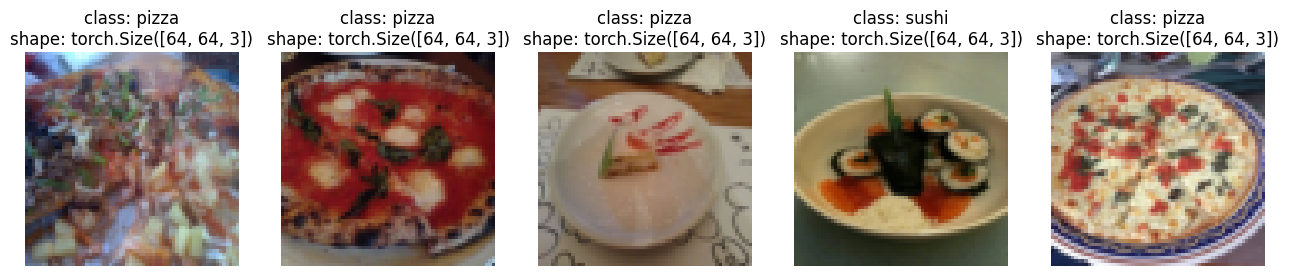

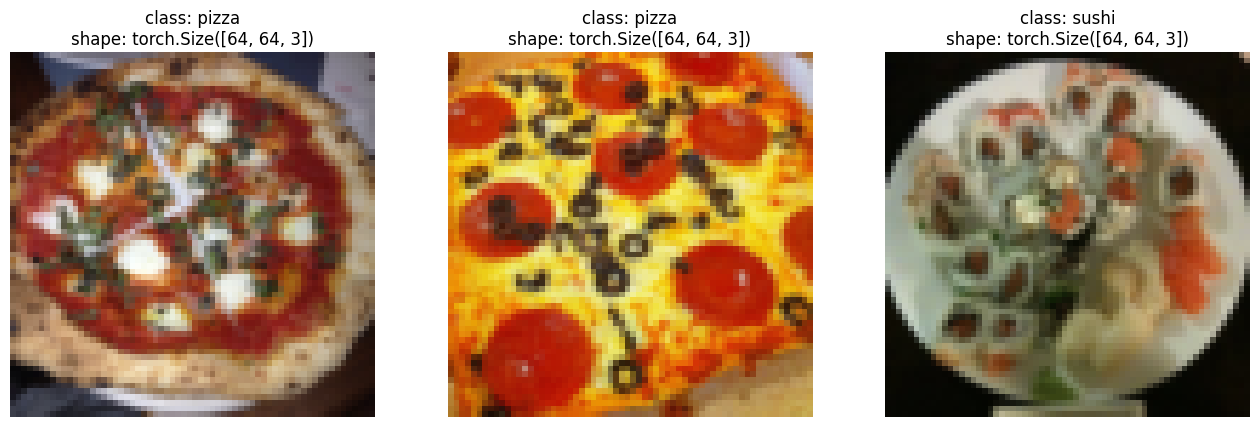

In [57]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=3, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

In [58]:
#now we convert our custom Datasets into DataLoaders

# Turn train and test custom Dataset's into DataLoader's

train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=32, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1380b8fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x14b95dc60>)

In [59]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


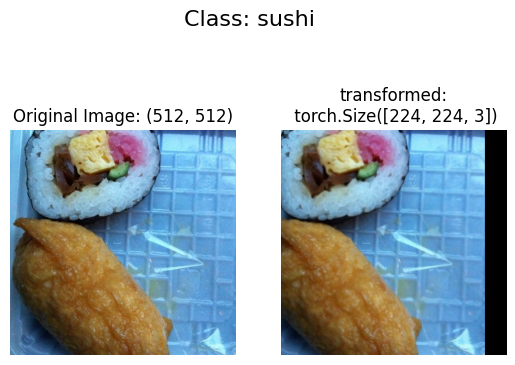

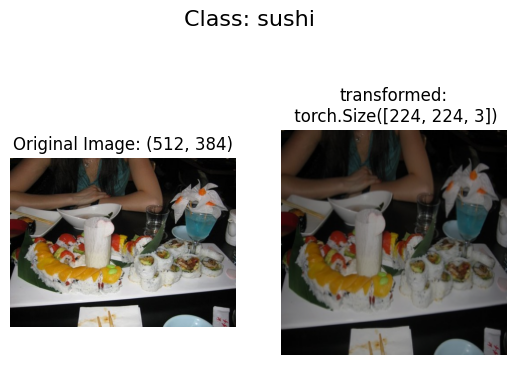

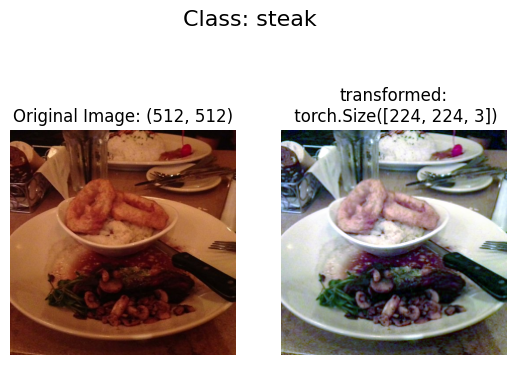

In [60]:
#image augmentation
#other forms of transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

#test the augmented images
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [61]:
#model0 will take inputs from the images without any data augmentation

#creating transforms first, simple first

simple_transform = simple_transform = transforms.Compose([ 
                                            transforms.Resize((64, 64)),
                                            transforms.ToTensor(),
])

#load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform,
)

#create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

len(train_dataloader_simple), len(test_dataloader_simple)

Creating DataLoader's with batch size 32 and 11 workers.


(8, 3)

## CNN Model Architecture

The architecture is a replication of the TinyVGG model, a CNN suited for small-scale image classification tasks. The architecture includes:

- A few convolutional layers with ReLU activations and max pooling
- Flattening and fully connected layers
- Softmax-style output with 3 units (one per class)

This lightweight model is sufficient for this small dataset but can be extended for more complexity.


In [62]:
#creating architecture TinyVGG

class TinyVGG0(nn.Module):
    def __init__(self, 
                 input_shape:int, 
                 output_shape:int, 
                 hidden_units:int):
        
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x=self.classifier_layers(x)
        # print(x.shape)
        
        return x
        #return self.classifier_layers(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)

model_0 = TinyVGG0(input_shape=3,
                   output_shape=len(train_data.classes),
                   hidden_units=10).to(device)

model_0

TinyVGG0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [63]:
#test one forward pass pre-training

# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0208, -0.0020,  0.0095]])

Output prediction probabilities:
tensor([[0.3371, 0.3295, 0.3333]])

Output prediction label:
tensor([0])

Actual label:
0


In [64]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG0                                 [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [65]:
#training and testing loops

def train_step(model, dataloader, loss_fn, optimizer):
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred_logits = model(X)

        #loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        #acc
        y_pred_class = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred_logits)

    #adjust metrics

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            #loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            #acc
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


## Training the Model

The model is trained using CrossEntropyLoss and an optimizer such as SGD or Adam.

Due to the small dataset size, overfitting is a likely concern, and training might complete quickly.


In [66]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [67]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG0(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0843 | train_acc: 0.3984 | test_loss: 1.0607 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time: 304.681 seconds


In [68]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [69]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

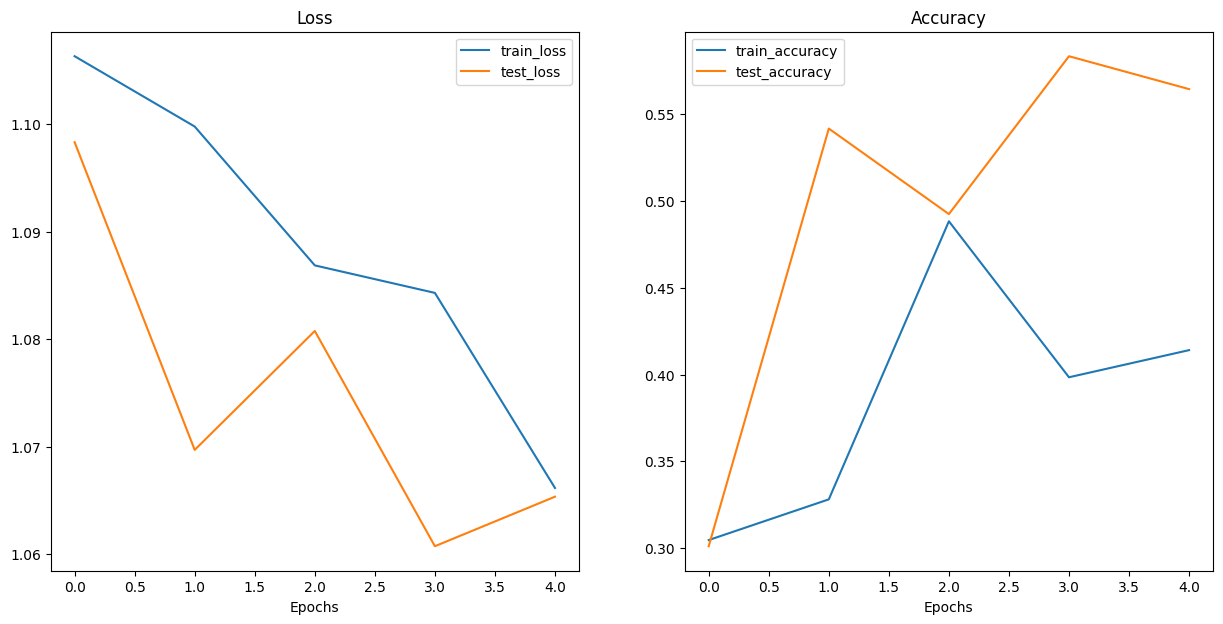

In [70]:
plot_loss_curves(model_0_results)

## Conclusion

This notebook shows how to:
- Work with a custom image dataset using PyTorch
- Set up a directory structure compatible with `ImageFolder`
- Train a simple CNN to classify food images

This project is a foundation for more advanced work such as:
- Transfer learning
- Data augmentation
- Deployment or inference scripts
